<a href="https://colab.research.google.com/github/ChrisW2420/FedDistill/blob/main/Copy_of_knowledge_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Distillation

**Author:** [Kenneth Borup](https://twitter.com/Kennethborup)<br>
**Date created:** 2020/09/01<br>
**Last modified:** 2020/09/01<br>
**Description:** Implementation of classical Knowledge Distillation.

## Introduction to Knowledge Distillation

Knowledge Distillation is a procedure for model
compression, in which a small (student) model is trained to match a large pre-trained
(teacher) model. Knowledge is transferred from the teacher model to the student
by minimizing a loss function, aimed at matching softened teacher logits as well as
ground-truth labels.

The logits are softened by applying a "temperature" scaling function in the softmax,
effectively smoothing out the probability distribution and revealing
inter-class relationships learned by the teacher.

**Reference:**

- [Hinton et al. (2015)](https://arxiv.org/abs/1503.02531)

## Setup

In [1]:
!pip install --upgrade keras
!pip install -qq -U wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.8 MB/s eta 0:00:00


In [2]:
import os
import math
from tensorflow import keras
from keras import layers
from keras import ops
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb
from wandb.keras import WandbMetricsLogger
from keras.callbacks import Callback
from keras.applications import ResNet50
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# configs = dict(
#     num_classes = 10,
#     shuffle_buffer = 1024,
#     batch_size = 64,
#     image_size = 28,
#     image_channels = 1,
#     earlystopping_patience = 3,
#     learning_rate = 1e-3,
#     epochs = 3
# )

## Construct `Distiller()` class

The custom `Distiller()` class, overrides the `Model` methods `compile`, `compute_loss`,
and `call`. In order to use the distiller, we need:

- A trained teacher model
- A student model to train
- A student loss function on the difference between student predictions and ground-truth
- A distillation loss function, along with a `temperature`, on the difference between the
soft student predictions and the soft teacher labels
- An `alpha` factor to weight the student and distillation loss
- An optimizer for the student and (optional) metrics to evaluate performance

In the `compute_loss` method, we perform a forward pass of both the teacher and student,
calculate the loss with weighting of the `student_loss` and `distillation_loss` by `alpha`
and `1 - alpha`, respectively. Note: only the student weights are updated.

In [21]:
class Distiller(keras.Model):
    def __init__(self, teacher, student, alpha=0.1, temperature=3, **kwargs):
        super(Distiller, self).__init__(**kwargs)
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha, temperature, **kwargs):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics, **kwargs)
        self.student_loss_fn = student_loss_fn
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=self.student_loss_fn)
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass of teacher with no gradient tracking
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # Forward pass of the student
            student_predictions = self.student(x, training=True)

            # Calculate the task-specific loss
            task_loss = self.student_loss_fn(y, student_predictions)

            # Calculate the soft targets and the distillation loss
            soft_targets = tf.nn.softmax(teacher_predictions / self.temperature)
            student_soft = tf.nn.softmax(student_predictions / self.temperature)
            distillation_loss = self.distillation_loss_fn(soft_targets, student_soft)

            # Calculate the total loss
            total_loss = (1 - self.alpha) * task_loss + self.alpha * distillation_loss * (self.temperature ** 2)

        # Compute gradients and update weights
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"task_loss": task_loss, "distillation_loss": distillation_loss, "total_loss": total_loss})
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass of the student
        y_pred = self.student(x, training=False)

        # Calculate the task-specific loss
        task_loss = self.student_loss_fn(y, y_pred)

        # Update the metrics
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

## CNN models

In [6]:
# small
def smallCNN():
  smallCNN = keras.Sequential(
      [
          keras.Input(shape=(28, 28, 1)),
          layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          layers.Flatten(),
          layers.Dense(10),
      ],
      name="smallcnn",
  )
  return smallCNN

# medium
def mediumCNN():
  mediumCNN = keras.Sequential(
      [
          keras.Input(shape=(28, 28, 1)),
          layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          layers.Flatten(),
          layers.Dense(10),
      ],
      name="mediumcnn",
  )
  return mediumCNN

# big
def bigCNN():
  bigCNN = keras.Sequential(
      [
          keras.Input(shape=(28, 28, 1)),
          layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          layers.Flatten(),
          layers.Dense(10),
      ],
      name="mediumcnn",
  )
  return bigCNN

## Prepare the dataset

The dataset used for training the teacher and distilling the teacher is
[MNIST](https://keras.io/api/datasets/mnist/), and the procedure would be equivalent for
any other
dataset, e.g. [CIFAR-10](https://keras.io/api/datasets/cifar10/), with a suitable choice
of models. Both the student and teacher are trained on the training set and evaluated on
the test set.

In [7]:
# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Create student and teacher models

In [22]:
def train_CNN(model, _epoch, _name):
  model.compile(
      optimizer=keras.optimizers.Adam(),
      loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
  )
  run = wandb.init(
    project = "kdbasicexpr",
    config = {"architecture": "CNN",
              "dataset": "MNIST",
              "epochs": _epoch,
              },
    # run name
    name = _name
  )
  # Train and evaluate teacher on data.
  model.fit(x_train, y_train, epochs=_epoch,validation_data=(x_test, y_test), callbacks=[WandbMetricsLogger()])
  eval_metrics = model.evaluate(x_test, y_test)
  run.finish()
  return model, eval_metrics

def train_distill(_student, _teacher, _epoch, _alpha, _temp, _name):
  distiller = Distiller(student=_student, teacher=_teacher)
  distiller.compile(
      optimizer=keras.optimizers.Adam(),
      metrics=[keras.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=keras.losses.KLDivergence(),
      alpha=_alpha,
      temperature=_temp,
  )

  run = wandb.init(
    project = "kdbasicexpr",
    config = {"architecture": "CNN",
              "dataset": "MNIST",
              "epochs": _epoch,
              },
    # run name
    name = _name
  )
  # Distill teacher to student

  distiller.fit(x_train, y_train, epochs=_epoch, validation_data=(x_test, y_test), callbacks=[WandbMetricsLogger()])
  eval_metrics = distiller.evaluate(x_test, y_test)
  run.finish()
  return distiller, eval_metrics

def cm_plot(model):
  # Preprocess the data
  y_test_cm = to_categorical(y_test, 10)
  # Predict the test set
  predictions = model.predict(x_test)

  # Convert predictions to class labels
  predicted_classes = np.argmax(predictions, axis=1)
  actual_classes = np.argmax(y_test_cm, axis=1)

  # Generate the confusion matrix
  cm = confusion_matrix(actual_classes, predicted_classes)
  cm = (cm/ cm.sum(axis=1))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm.round(2), display_labels=['0', '1','2','3','4','5','6','7','8','9'])
  disp.plot()
  plt.show()

  print(cm.diagonal() / cm.sum(axis=1))

# Experiments

## Compare the performance with same student and teacher model


In [24]:
CNNls = [smallCNN(), mediumCNN(), bigCNN()]
CNNnames = ['small', 'medium', 'big']
output = []
combo = []
for idx, m in enumerate(CNNls):
  t_config = m.get_config()
  s_config = m.get_config()
  t_model = keras.models.Sequential.from_config(t_config)
  d_model = keras.models.Sequential.from_config(s_config)
  s_model = keras.models.Sequential.from_config(s_config)
  teacher, teval = train_CNN(t_model, 10, 'teacher'+CNNnames[idx])
  distill, deval = train_distill(d_model, teacher, 10, 0.1, 5, 'distill'+CNNnames[idx])
  student, seval = train_CNN(s_model, 10, 'rawstu'+CNNnames[idx])
  output.append([teval, deval, seval])
  if seval[1] < deval[1]:
    combo.append(CNNnames[idx], CNNnames[idx])
print(output)
print(combo)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.6836 - sparse_categorical_accuracy: 0.7891 - val_loss: 0.2837 - val_sparse_categorical_accuracy: 0.9168
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2665 - sparse_categorical_accuracy: 0.9201 - val_loss: 0.1639 - val_sparse_categorical_accuracy: 0.9538
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1605 - sparse_categorical_accuracy: 0.9513 - val_loss: 0.1311 - val_sparse_categorical_accuracy: 0.9607
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1236 - sparse_categorical_accuracy: 0.9638 - val_loss: 0.0968 - val_sparse_categorical_accuracy: 0.9701
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0996 - sparse_categorical_accuracy: 0.9692 - val_loss: 0.0762 - val_sparse_categorical_accuracy: 0.9754
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0837 - sparse_categorical_accuracy: 0.9741 - val_loss: 0.0721 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▄▃▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▅▆▇▇█████
epoch/val_loss,█▄▃▂▁▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▅▆▇██████
epoch/epoch,9
epoch/loss,0.06224
epoch/sparse_categorical_accuracy,0.98055
epoch/val_loss,0.06481
epoch/val_sparse_categorical_accuracy,0.979


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - sparse_categorical_accuracy: 0.7779 - distillation_loss: 0.2062 - loss: -2.4016 - task_loss: 0.4617 - total_loss: 0.9310 - val_loss: -1.1753 - val_sparse_categorical_accuracy: 0.9268
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - sparse_categorical_accuracy: 0.9387 - distillation_loss: 0.0707 - loss: -0.5236 - task_loss: 0.1804 - total_loss: 0.3391 - val_loss: 0.5210 - val_sparse_categorical_accuracy: 0.9668
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9665 - distillation_loss: 0.0367 - loss: 0.4310 - task_loss: 0.1084 - total_loss: 0.1894 - val_loss: 0.5049 - val_sparse_categorical_accuracy: 0.9729
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9723 - distillation_loss: 0.0284 - loss: 0.4571 - task_loss: 0.0887 - total_loss: 0.1509 - val_loss: 0.4833 - val_sparse_categorical_accuracy: 0.9742
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/

epoch/distillation_loss,█▅▂▂▂▂▁▁▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▁▇██████▇▇
epoch/sparse_categorical_accuracy,▁▆▇▇██████
epoch/task_loss,██▅▂▂▃▃▁▂▁
epoch/total_loss,█▆▄▂▂▂▂▁▂▁
epoch/val_loss,▁████▇▇▇▇▆
epoch/val_sparse_categorical_accuracy,▁▆▇▇██████
epoch/distillation_loss,0.01661
epoch/epoch,9
epoch/loss,0.12551


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.6956 - sparse_categorical_accuracy: 0.7916 - val_loss: 0.1425 - val_sparse_categorical_accuracy: 0.9568
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1439 - sparse_categorical_accuracy: 0.9565 - val_loss: 0.0970 - val_sparse_categorical_accuracy: 0.9723
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1062 - sparse_categorical_accuracy: 0.9684 - val_loss: 0.0824 - val_sparse_categorical_accuracy: 0.9750
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0896 - sparse_categorical_accuracy: 0.9733 - val_loss: 0.0808 - val_sparse_categorical_accuracy: 0.9756
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0805 - sparse_categorical_accuracy: 0.9752 - val_loss: 0.0733 - val_sparse_categorical_accuracy: 0.9762
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0735 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0666 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▁▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇██████
epoch/val_loss,█▄▃▃▂▁▂▂▂▁
epoch/val_sparse_categorical_accuracy,▁▆▆▇▇▇▇▇▇█
epoch/epoch,9
epoch/loss,0.06135
epoch/sparse_categorical_accuracy,0.98113
epoch/val_loss,0.06085
epoch/val_sparse_categorical_accuracy,0.9805


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.5603 - sparse_categorical_accuracy: 0.8237 - val_loss: 0.0852 - val_sparse_categorical_accuracy: 0.9745
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0910 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.0627 - val_sparse_categorical_accuracy: 0.9788
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0733 - sparse_categorical_accuracy: 0.9781 - val_loss: 0.0587 - val_sparse_categorical_accuracy: 0.9799
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0621 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.0740 - val_sparse_categorical_accuracy: 0.9767
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0534 - sparse_categorical_accuracy: 0.9837 - val_loss: 0.0516 - val_sparse_categorical_accuracy: 0.9836
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0482 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.0575 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▄▃▆▂▃▁▁▂▂
epoch/val_sparse_categorical_accuracy,▁▄▅▂▇▅█▇▇▇
epoch/epoch,9
epoch/loss,0.03775
epoch/sparse_categorical_accuracy,0.98768
epoch/val_loss,0.05405
epoch/val_sparse_categorical_accuracy,0.9836


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - sparse_categorical_accuracy: 0.8152 - distillation_loss: 0.1578 - loss: -2.1945 - task_loss: 0.2725 - total_loss: 0.6398 - val_loss: -2.1132 - val_sparse_categorical_accuracy: 0.9746
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - sparse_categorical_accuracy: 0.9706 - distillation_loss: 0.0447 - loss: -1.9262 - task_loss: 0.0906 - total_loss: 0.1932 - val_loss: -1.6825 - val_sparse_categorical_accuracy: 0.9810
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9787 - distillation_loss: 0.0327 - loss: -1.6441 - task_loss: 0.0670 - total_loss: 0.1420 - val_loss: -1.3000 - val_sparse_categorical_accuracy: 0.9855
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - sparse_categorical_accuracy: 0.9823 - distillation_loss: 0.0267 - loss: -1.4529 - task_loss: 0.0552 - total_loss: 0.1163 - val_loss: -1.3381 - val_sparse_categorical_accuracy: 0.9813
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6

epoch/distillation_loss,█▅▄▄▁▂▂▂▂▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▁▄▆▆▇▇▇▇██
epoch/sparse_categorical_accuracy,▁▆▇▇██████
epoch/task_loss,▁▅▅█▁▂▁▁▁▁
epoch/total_loss,▃▆▅█▁▂▁▁▁▁
epoch/val_loss,▁▄▇▆▅▆▇▆▇█
epoch/val_sparse_categorical_accuracy,▁▅▇▅▇▇███▇
epoch/distillation_loss,0.0133
epoch/epoch,9
epoch/loss,-1.20719


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.5640 - sparse_categorical_accuracy: 0.8289 - val_loss: 0.1140 - val_sparse_categorical_accuracy: 0.9641
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1092 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.0720 - val_sparse_categorical_accuracy: 0.9760
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0900 - sparse_categorical_accuracy: 0.9707 - val_loss: 0.0695 - val_sparse_categorical_accuracy: 0.9774
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0711 - sparse_categorical_accuracy: 0.9776 - val_loss: 0.0564 - val_sparse_categorical_accuracy: 0.9819
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0589 - sparse_categorical_accuracy: 0.9807 - val_loss: 0.0512 - val_sparse_categorical_accuracy: 0.9832
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0575 - sparse_categorical_accuracy: 0.9820 - val_loss: 0.0490 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▄▃▂▁▁▂▁▂▂
epoch/val_sparse_categorical_accuracy,▁▅▅▇▇█▇█▇▆
epoch/epoch,9
epoch/loss,0.04216
epoch/sparse_categorical_accuracy,0.98643
epoch/val_loss,0.05813
epoch/val_sparse_categorical_accuracy,0.9804


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.4093 - sparse_categorical_accuracy: 0.8686 - val_loss: 0.0595 - val_sparse_categorical_accuracy: 0.9800
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0676 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.0500 - val_sparse_categorical_accuracy: 0.9831
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0513 - sparse_categorical_accuracy: 0.9847 - val_loss: 0.0412 - val_sparse_categorical_accuracy: 0.9874
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0391 - sparse_categorical_accuracy: 0.9869 - val_loss: 0.0346 - val_sparse_categorical_accuracy: 0.9876
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0359 - sparse_categorical_accuracy: 0.9889 - val_loss: 0.0369 - val_sparse_categorical_accuracy: 0.9884
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0274 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.0449 - val_sparse_categorical_accuracy:

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇▇████
epoch/val_loss,█▅▃▁▂▄▅▄▄▅
epoch/val_sparse_categorical_accuracy,▁▄▇▇█▆▆▆▇▅
epoch/epoch,9
epoch/loss,0.01994
epoch/sparse_categorical_accuracy,0.99357
epoch/val_loss,0.04833
epoch/val_sparse_categorical_accuracy,0.985


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - sparse_categorical_accuracy: 0.8609 - distillation_loss: 0.1579 - loss: -0.8969 - task_loss: 0.2161 - total_loss: 0.5892 - val_loss: -0.2770 - val_sparse_categorical_accuracy: 0.9780
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9785 - distillation_loss: 0.0463 - loss: -0.4989 - task_loss: 0.0650 - total_loss: 0.1742 - val_loss: -0.6693 - val_sparse_categorical_accuracy: 0.9857
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - sparse_categorical_accuracy: 0.9860 - distillation_loss: 0.0318 - loss: -0.7136 - task_loss: 0.0446 - total_loss: 0.1197 - val_loss: -0.9297 - val_sparse_categorical_accuracy: 0.9862
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - sparse_categorical_accuracy: 0.9898 - distillation_loss: 0.0256 - loss: -0.8911 - task_loss: 0.0351 - total_loss: 0.0955 - val_loss: -0.8535 - val_sparse_categorical_accuracy: 0.9874
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 

epoch/distillation_loss,█▃▂▂▂▂▂▂▁▁
epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,▇█▅▃▂▂▂▂▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/task_loss,█▁▁▁▁▁▂▁▁▁
epoch/total_loss,█▂▁▂▂▁▂▁▁▁
epoch/val_loss,█▅▂▃▃▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▆▆▇▇█▆▆▇▇
epoch/distillation_loss,0.01385
epoch/epoch,9
epoch/loss,-1.12062


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.4336 - sparse_categorical_accuracy: 0.8630 - val_loss: 0.0653 - val_sparse_categorical_accuracy: 0.9795
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0632 - sparse_categorical_accuracy: 0.9808 - val_loss: 0.0545 - val_sparse_categorical_accuracy: 0.9829
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0446 - sparse_categorical_accuracy: 0.9853 - val_loss: 0.0457 - val_sparse_categorical_accuracy: 0.9847
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0383 - sparse_categorical_accuracy: 0.9873 - val_loss: 0.0515 - val_sparse_categorical_accuracy: 0.9837
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0331 - sparse_categorical_accuracy: 0.9886 - val_loss: 0.0379 - val_sparse_categorical_accuracy: 0.9877
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0246 - sparse_categorical_accuracy: 0.9921 - val_loss: 0.0469 - val_sparse_categorical_accuracy

epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/loss,█▃▂▂▂▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▆▇▇▇█████
epoch/val_loss,█▅▃▅▁▄▁▂▃▄
epoch/val_sparse_categorical_accuracy,▁▄▅▄▇▅█▆▇▆
epoch/epoch,9
epoch/loss,0.01927
epoch/sparse_categorical_accuracy,0.99363
epoch/val_loss,0.04888
epoch/val_sparse_categorical_accuracy,0.986


[[[0.06480518728494644, 0.9789999723434448], [0.08559640496969223, 0.08559640496969223, 0.9793000221252441, 0.08559640496969223, 0.9793000221252441, 0.9793000221252441], [0.06085257604718208, 0.9804999828338623]], [[0.054047711193561554, 0.9836000204086304], [-1.090444564819336, -1.090444564819336, 0.9854000210762024, -1.090444564819336, 0.9854000210762024, 0.9854000210762024], [0.05813028663396835, 0.980400025844574]], [[0.048328299075365067, 0.9850000143051147], [-1.0756947994232178, -1.0756947994232178, 0.9886000156402588, -1.0756947994232178, 0.9886000156402588, 0.9886000156402588], [0.04888257011771202, 0.9860000014305115]]]
[]


## Compare the performance between with and without KD

In [ ]:
CNNls = [smallCNN(), mediumCNN(), bigCNN()]
CNNnames = ['small', 'medium', 'big']
output = []
combo = []
for idx_t, t in enumerate(CNNls):
  t_config = t.get_config()
  for idx_s ,s in enumerate(CNNls):
    s_config = s.get_config()
    t_model = keras.models.Sequential.from_config(t_config)
    d_model = keras.models.Sequential.from_config(s_config)
    s_model = keras.models.Sequential.from_config(s_config)
    teacher, teval = train_CNN(t_model, 5)
    distill, deval = train_distill(d_model, teacher, 3, 0.1, 5)
    student, seval = train_CNN(s_model, 3)
    output.append([teval, deval, seval])
    if seval[1] < deval[1]:
      combo.append(CNNnames[idx_t], CNNnames[idx_s])
print(output)
print(combo)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.6794 - sparse_categorical_accuracy: 0.7937
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1728 - sparse_categorical_accuracy: 0.9476
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1240 - sparse_categorical_accuracy: 0.9619
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1146 - sparse_categorical_accuracy: 0.9647
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1018 - sparse_categorical_accuracy: 0.9687
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1068 - sparse_categorical_accuracy: 0.9654
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1068 - sparse_categorical_accuracy: 0.9654
Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 1.7333 - sparse_categorical_accuracy: 0.7040
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0415 - sparse_categorical_accuracy: 0.9497
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0221 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


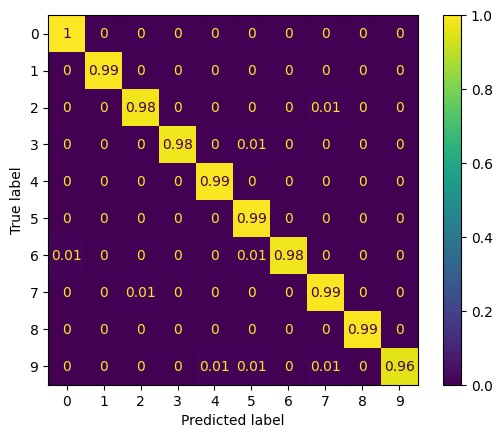

[0.99695665 0.99409003 0.98334669 0.97812723 0.99013456 0.99092707
 0.9784044  0.98549561 0.98563031 0.96361414]


In [ ]:
# Preprocess the data
y_test_cm = to_categorical(y_test, 10)
# Predict the test set
predictions = teacher.predict(x_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
actual_classes = np.argmax(y_test_cm, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(actual_classes, predicted_classes)
cm = (cm/ cm.sum(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm.round(2), display_labels=['0', '1','2','3','4','5','6','7','8','9'])
disp.plot()
plt.show()

print(cm.diagonal() / cm.sum(axis=1))

## observe model weights

In [ ]:
Tweights, Tbiases =  teacher.layers[-1].get_weights()
# Dweights, Dbiases =  distiller.layers[-1].get_weights()
Sweights, Sbiases =  student_scratch.layers[-1].get_weights()

print("Weights of the output layer:\n", Tweights, Sweights)
print("Biases of the output layer:\n", Tbiases, Sbiases)

Weights of the output layer:
 [[ 0.1394549  -0.00424952  0.09599148 ...  0.23841085 -0.06017627
  -0.0249629 ]
 [ 0.24516042  0.06631715 -0.16127941 ... -0.25794384  0.27884018
   0.2643842 ]
 [ 0.18706723 -0.6165633  -0.1586415  ... -0.26791924 -0.00648287
   0.17354843]
 ...
 [-0.39510736 -0.45938048  0.35964316 ... -0.17689064  0.25126883
   0.09409092]
 [-0.41765693 -0.01680286  0.07312652 ...  0.12978503  0.18897396
  -0.33629167]
 [ 0.03432905 -0.32070976 -0.35578766 ...  0.17976171 -0.0200269
   0.00693635]] [[-0.09021454 -0.07098527 -0.05728453 ... -0.11388993 -0.03257424
  -0.09754462]
 [ 0.07376936  0.1141155  -0.06223818 ... -0.09451519  0.0975888
   0.14076512]
 [ 0.04146593 -0.07241505  0.0007681  ... -0.02884299  0.03016947
  -0.00308976]
 ...
 [ 0.09587643 -0.07799426  0.16460563 ...  0.04809425 -0.25675476
  -0.02816536]
 [ 0.06399062  0.08341114  0.03668668 ...  0.02143194 -0.12983309
  -0.01744191]
 [ 0.0602922   0.11237707 -0.08031515 ... -0.04815526 -0.01092417
   0

## Find the most suitable param for each model combimation

## SIMKD

In [ ]:
def train_simKD(teacher, student, _epoch, _alpha, _temp):
  t_weights = teacher.layers[-1].get_weights()[0]
  s_weights = student.layers[-1].get_weights()[0]
  # Spatial Dimension Alignment
  t_classifier = keras.layers.Reshape(s_weights.shape)(t_weights)
  student.layers[-1].set_weights(t_classifier)
  # Freeze the last layer (prevent it from updating)
  student.layers[-1].trainable = False
  return train_distill(student, teacher, _epoch, _alpha, _temp)



In [ ]:
student = smallCNN()
t_weights = teacher.layers[-1].get_weights()[0]
s_weights = student.layers[-1].get_weights()[0]
print(t_weights.shape, s_weights.shape)
poolsize = math.ceil(s_weights.shape[0]/t_weights.shape[0])
tmp = keras.Sequential([l for l in student.layers[:-1], layers.MaxPooling2D(pool_size=(poolsize, poolsize), strides=(1, 1), padding="same"), student.layers[-1],], name = 'simkd')


print(t_weights.shape, tmp.shape)
# # Spatial Dimension Alignment
# student.layers[-1].set_weights(t_classifier)
# # Freeze the last layer (prevent it from updating)
# student.layers[-1].trainable = False
# train_distill(student, teacher, 3, 0.1, 5)

SyntaxError: invalid syntax (<ipython-input-39-1068b7c82c52>, line 6)

In [ ]:
# t_model = mediumCNN()
d_model = smallCNN()
s_model = smallCNN()
simmodel = smallCNN()
# teacher, teval = train_CNN(t_model, 5)
simkdmodel, simkdeval = train_simKD(simmodel, teacher, 3, 0.1, 5)
distill, deval = train_distill(d_model, teacher, 3, 0.1, 5)
student, seval = train_CNN(s_model, 3)
print(teval, deval, seval, simkdeval)

ValueError: The total size of the tensor must be unchanged. Received: input_shape=(10,), target_shape=(256, 10)

In [ ]:
teacher_weights, teacher_bias = teacher.layers[-1].get_weights()

print(teacher_weights.shape)
dis_weights = distiller.layers[-1].get_weights()[0]
print(dis_weights.shape)
stu_w = student_scratch.layers[-1].get_weights()[0]
print(stu_w.shape)

(256, 10)
(3, 3, 1, 8)
(256, 10)


In [ ]:
student_simkd = smallCNN()


In [ ]:
# Assign weights to the last layer
student_simkd.layers[-1].set_weights([teacher_weights, teacher_bias])

# Freeze the last layer (prevent it from updating)
student_simkd.layers[-1].trainable = False

In [ ]:
student_simkd.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
# Train and evaluate student trained from scratch.

student_scratch.fit(x_train, y_train, epochs=3, callbacks=[WandBCustomCallback()])
eval_metrics = student_scratch.evaluate(x_test, y_test)

Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0878 - sparse_categorical_accuracy: 0.9721
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0806 - sparse_categorical_accuracy: 0.9749
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9771
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1002 - sparse_categorical_accuracy: 0.9671


# EMNIST

https://github.com/wandb/awesome-dl-projects/blob/master/ml-tutorial/Investigating_EMNIST.ipynb

In [ ]:
import tensorflow_datasets as tfds
from tqdm import tqdm

In [ ]:
wandb.init(entity='iit-bhu', project='investigate-emnist')

epoch,▁▃▅▆█▁▃▅▁▃▅
loss,▆▂▂▂▂▂▁▁█▃▃
s_eval_accuracy,▁
s_eval_loss,▁
ss_eval_accuracy,▁
ss_eval_loss,▁
t_eval_accuracy,▁
t_eval_loss,▁
epoch,2
loss,0.10009
s_eval_accuracy,0.973


In [ ]:
(train_ds, validation_ds) = tfds.load(
    "emnist/byclass",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True

)

builder = tfds.builder('emnist/bymerge')
builder.info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

NonMatchingChecksumError: Artifact https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip, downloaded to /root/tensorflow_datasets/downloads/itl.nist.gov_iaui_vip_cs_links_EMNIST_gzipi4VnNviDSrfd9Zju6qv40flc3wr22t8ldulNStS6tmk.zip.tmp.c76a8d8c76884eec8b42e98ab3a5d3e1/itl, has wrong checksum:
* Expected: UrlInfo(size=535.73 MiB, checksum='fb9bb67e33772a9cc0b895e4ecf36d2cf35be8b709693c3564cea2a019fcda8e', filename='gzip.zip')
* Got: UrlInfo(size=108.59 KiB, checksum='f50e850b1a77c59d1322807a84d3bd201ed58c665dfd333ddd43c841c9899294', filename='itl')
To debug, see: https://www.tensorflow.org/datasets/overview#fixing_nonmatchingchecksumerror